<a href="https://colab.research.google.com/github/Mino94/amazon-recommender-system/blob/main/amazone_recommender_system_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 추천 시스템(Recoomender Systems)

- 컨텐츠 기반 필터링(content-based filtering)
 - 사용자의 이전 행동과 명시적 피드백을 통해 사용자가 좋아하는 것과 유사한 항목을 추천
- 협업 필터링 (collaborative filtering)
 - 사용자와 항목간의 유사성을 동시에 사용해 추천

# EDA(탐색적 데이터 분석)

- Fashion Item Info Data
- User Review Info Data


In [1]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz

--2021-06-09 04:15:53--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93185167 (89M) [application/octet-stream]
Saving to: ‘AMAZON_FASHION.json.gz’

AMAZON_FASHION.json 100%[===================>]  88.87M  19.8MB/s    in 5.5s    

2021-06-09 04:15:59 (16.3 MB/s) - ‘AMAZON_FASHION.json.gz’ saved [93185167/93185167]



In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_AMAZON_FASHION.json.gz

--2021-06-09 04:15:59--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_AMAZON_FASHION.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31372500 (30M) [application/octet-stream]
Saving to: ‘meta_AMAZON_FASHION.json.gz’

meta_AMAZON_FASHION 100%[===================>]  29.92M  11.8MB/s    in 2.5s    

2021-06-09 04:16:02 (11.8 MB/s) - ‘meta_AMAZON_FASHION.json.gz’ saved [31372500/31372500]



In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
import json
import gzip
from urllib.request import urlopen

import random
from collections import defaultdict

## Fashion Item Data

In [5]:
### load the meta data

data = []
with gzip.open('meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

186637
{'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'image': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682'}


In [6]:
df = pd.DataFrame.from_dict(data)

df.head()

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
item_info_df = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(item_info_df))

430
186207


In [8]:
item_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186207 entries, 0 to 186636
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         186207 non-null  object
 1   image         186207 non-null  object
 2   brand         186207 non-null  object
 3   feature       186207 non-null  object
 4   rank          186207 non-null  object
 5   date          186207 non-null  object
 6   asin          186207 non-null  object
 7   description   186207 non-null  object
 8   price         186207 non-null  object
 9   also_view     186207 non-null  object
 10  also_buy      186207 non-null  object
 11  fit           186207 non-null  object
 12  details       186207 non-null  object
 13  similar_item  186207 non-null  object
 14  tech1         186207 non-null  object
dtypes: object(15)
memory usage: 22.7+ MB


## User Review data 

In [103]:
data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

print(len(data))
print(data[0])

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [104]:
df = pd.DataFrame.from_dict(data)

print(len(df))

883636


In [105]:
df_fashion_review = df[(df.verified == True)]
df_fashion_review = df_fashion_review.sort_values(by=['unixReviewTime'], ignore_index=True)
df_fashion_review = df_fashion_review[(df_fashion_review.unixReviewTime >= 1483196400)] # 2017년 이후 리뷰

print(len(df_fashion_review))
df_fashion_review.head()

225339


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
603360,1.0,True,"01 1, 2017",A2D9XU6VBGO4HU,B01DBMTFA4,Amazon Customer,Sad,One Star,1483228800,NaN,{'Color:': ' Grey'},NaN
603361,5.0,True,"01 1, 2017",A1TQIXB48V40T7,B019NQ5Q14,Kait,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800,NaN,NaN,NaN
603362,1.0,True,"01 1, 2017",AF7241JYDTI8A,B01HD1C7PY,Rhonda,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800,NaN,NaN,NaN
603363,5.0,True,"01 1, 2017",AKHU2R9PJP22D,B017UVT3F4,J Cole,Granddaughter loves it.,Five Stars,1483228800,NaN,"{'Size:': ' 5', 'Color:': ' Grey Multi'}",NaN
603364,5.0,True,"01 1, 2017",A3BJHX7M023ZBI,B018W8N7EW,Moroccomom,Nice tee for shorts and capris.,Great tee shirt,1483228800,NaN,NaN,NaN


In [106]:
review_columns = ['overall', 'reviewerID', 'asin', 'reviewText', 'summary','unixReviewTime']

df_fashion_review = df_fashion_review[review_columns]
df_fashion_review.head()

,overall,reviewerID,asin,reviewText,summary,unixReviewTime
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad,One Star,1483228800
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.,Five Stars,1483228800
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.,Great tee shirt,1483228800


In [107]:
# 컬럼명 변경
df_fashion_review.rename(columns={
    "overall": "rating",
    "reviewerID": "user_id",
    "asin": "item_id",
    "reviewText": "review",
    "unixReviewTime": "timestamp"
}, inplace=True)

df_fashion_review.head()

,rating,user_id,item_id,review,summary,timestamp
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad,One Star,1483228800
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m...","Thick and cozy, just as pictured. The tag ...",1483228800
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...,What a rip off!,1483228800
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.,Five Stars,1483228800
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.,Great tee shirt,1483228800


In [108]:
df_fashion_review.shape

(225339, 6)

In [109]:
df_fashion_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225339 entries, 603360 to 828698
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   rating     225339 non-null  float64
 1   user_id    225339 non-null  object 
 2   item_id    225339 non-null  object 
 3   review     224899 non-null  object 
 4   summary    225153 non-null  object 
 5   timestamp  225339 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 12.0+ MB


In [110]:
df_fashion_review.describe()['rating'].T

count    225339.000000
mean          3.981659
std           1.398888
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [111]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df_fashion_review.rating.min()))
print('Maximum rating is: %d' %(df_fashion_review.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


The rating of the product range from 0 to 1

## 결측치 처리

In [112]:
print('Number of missing values across columns: \n',df_fashion_review.isnull().sum())

Number of missing values across columns: 
 rating         0
user_id        0
item_id        0
review       440
summary      186
timestamp      0
dtype: int64


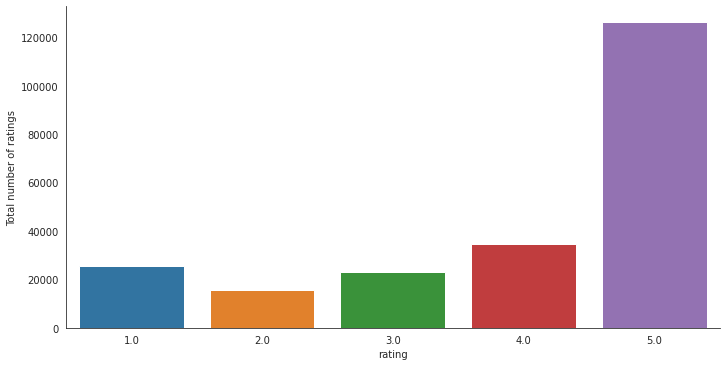

In [113]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df_fashion_review, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

### User와 Item 유일한 값

In [114]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df_fashion_review.shape[0])
print("Total No of Users   :", len(np.unique(df_fashion_review.user_id)))
print("Total No of products  :", len(np.unique(df_fashion_review.item_id)))

Total data 
--------------------------------------------------

Total no of ratings : 225339
Total No of Users   : 202923
Total No of products  : 60820


## 불필요한 컬럼 제거

- timestamp
- summary

In [115]:
df_fashion_review.drop(['timestamp', 'summary'], axis=1, inplace=True)

In [116]:
df_fashion_review.head()

,rating,user_id,item_id,review
603360,1.0,A2D9XU6VBGO4HU,B01DBMTFA4,Sad
603361,5.0,A1TQIXB48V40T7,B019NQ5Q14,"Thick and cozy, just as pictured. The tag is m..."
603362,1.0,AF7241JYDTI8A,B01HD1C7PY,I ordered a 2xx and it was soooooo small it fi...
603363,5.0,AKHU2R9PJP22D,B017UVT3F4,Granddaughter loves it.
603364,5.0,A3BJHX7M023ZBI,B018W8N7EW,Nice tee for shorts and capris.


In [117]:
df_fashion_review = df_fashion_review[['user_id', 'item_id', 'rating']]
df_fashion_review.columns = ['user', 'item', 'ratings']
df_fashion_review = df_fashion_review.reset_index()

In [118]:
df_fashion_review.head(2)

,index,user,item,ratings
0,603360,A2D9XU6VBGO4HU,B01DBMTFA4,1.0
1,603361,A1TQIXB48V40T7,B019NQ5Q14,5.0


In [119]:
df_fashion_review = df_fashion_review.drop(['index'], axis=1)


**어떤 사용자가 어떤 제품에 대해서 Rating을 몇 점을 주었는냐가 중요한 정보입니다.**

In [120]:
df_fashion_review.head()

,user,item,ratings
0,A2D9XU6VBGO4HU,B01DBMTFA4,1.0
1,A1TQIXB48V40T7,B019NQ5Q14,5.0
2,AF7241JYDTI8A,B01HD1C7PY,1.0
3,AKHU2R9PJP22D,B017UVT3F4,5.0
4,A3BJHX7M023ZBI,B018W8N7EW,5.0


In [28]:
item_meta = item_info_df.copy()
item_meta.columns = ['title', 'image', 'brand', 'feature', 'rank', 'date', 'item',
       'description', 'price', 'also_view', 'also_buy', 'fit', 'details',
       'similar_item', 'tech1']

item_meta.head()

,title,image,brand,feature,rank,date,item,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,,,,,,,,
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,,,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,,,,,,,,
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,,,,,,,
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,,,,,,,,
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,,$4.50,,,,,,


In [29]:
df_user_item_review = pd.merge(df_fashion_review, item_meta[['item', 'title']], on='item')

df_user_item_review.head()

,user,item,ratings,title
0,A2D9XU6VBGO4HU,B01DBMTFA4,1.0,HIBROS Love Knot Cufflinks Stainless Steel Tux...
1,A3CRODW9YZRIOT,B01DBMTFA4,1.0,HIBROS Love Knot Cufflinks Stainless Steel Tux...
2,A3D3597E9WA3CU,B01DBMTFA4,4.0,HIBROS Love Knot Cufflinks Stainless Steel Tux...
3,A3IWS9RVTPLHNH,B01DBMTFA4,5.0,HIBROS Love Knot Cufflinks Stainless Steel Tux...
4,A2T52GTR58N1Y7,B01DBMTFA4,5.0,HIBROS Love Knot Cufflinks Stainless Steel Tux...


In [30]:
# pandas version 문제 # Unstacked DataFrame is too big, causing int32 overflow
# 입력데이터 축소
df_user_item_review = df_user_item_review.head(50000) 
mf_df = df_user_item_review.pivot_table(index='user', columns = 'item', values = 'ratings').fillna(0)
mf_df.head()

item,B00008JVTT,B00066G516,B000ER9V68,B000GHMRLW,B000GHRZN2,B000HQ4P9O,B000JOOR7O,B000KPIHQ4,B000PHANNM,B000PMNS3E,B000PMPTF4,B000PMPTGI,B000POJKMU,B000POL05U,B000PQJQUY,B000V0IBDM,B000V588EO,B000VIUJLG,B000YFSR5G,B0014F57YY,B0014F8TIU,B0017U1KBK,B0018N8CHQ,B001AXC4YG,B001F8LJ92,B001G7R0CC,B001GIO77C,B001IKJOLW,B001LFP0EO,B001T4MSU6,B0027L8RSW,B002B90VTI,B002RC6FWQ,B002Z3N1HE,B003950BDY,B003BRC73C,B003ESTRW2,B003GJZDGS,B003MWEIA6,B003N7NXXS,...,B01GZZOZ8G,B01H059U4Y,B01H0C5A9Q,B01H1LQMXO,B01H1P2YTG,B01H1WHBPG,B01H2WVHQO,B01H3D4MZK,B01H3DCZBI,B01H3H4EB8,B01H4DGICE,B01H4P97HA,B01H5A1WUO,B01H62UHX4,B01H6FTQRY,B01H6Z43A4,B01H79VTDS,B01H7KY678,B01H7N6240,B01H7RIHEO,B01HBI0KW6,B01HBJW7DU,B01HBLV3K6,B01HC7ZP1M,B01HCHY6AI,B01HCJMCU2,B01HCVAP5O,B01HCWVWF0,B01HD1C7PY,B01HE9KXKQ,B01HEGKFKM,B01HEISONU,B01HFKK1AG,B01HFKZ57K,B01HFZM5RS,B01HH5SFNO,B01HHUQEY6,B01HIA2Y80,B01HIVIU82,B01HJGJ9LS
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A0010606488RW7ZH6EP7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0254933A6GXCEJ2WU0K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A02624829WK3PDCDC0XY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0640431RJ4E56LR9NV5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0650961HO7RGHL0IRPI,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
R = mf_df.iloc[:, : ].values
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Matrix Factorization

행렬을 분해하고 분해한 형렬을 변수로써 학습하는 것이다.

batch를 조정하지 않은 gradient descent를 사용하였고, 변수들은 numpy를 이용하여 보정하지 않은 완전한 랜덤 변수로 초기화하였다. 


In [34]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

class  MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose

    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):

            # rating이 존재하는 index를 기준으로 training
            for i in range(self._num_users):
                for j in range(self._num_items):
                    if self._R[i, j] > 0:
                        self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))

    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)


    def print_results(self):
        """
        print fit results
        """

        print("User Latent P:")
        print(self._P)
        print("Item Latent Q:")
        print(self._Q.T)
        print("P x Q:")
        print(self._P.dot(self._Q.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_P)
        print("Item Latent bias:")
        print(self._b_Q)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])

In [38]:
factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=30, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 0.0048
Iteration: 20 ; cost = 0.0041
Iteration: 30 ; cost = 0.0037


In [40]:
factorizer.print_results()

User Latent P:
[[-0.17368079  0.57999467 -0.6770974 ]
 [-0.1530638   0.26885893 -0.7405117 ]
 [ 0.65389756  0.95847104  1.20694327]
 ...
 [-0.9167477  -0.88355114 -0.0856989 ]
 [-0.64547151 -1.23206304 -0.5814954 ]
 [-0.02053239 -1.62120876  2.72709292]]
Item Latent Q:
[[ 0.31275544  0.09430755 -0.18894649 ...  1.1616688  -0.60510723
   0.03794032]
 [-0.24153662 -0.12060233  0.12534082 ... -0.46288938  0.04061749
   0.1447293 ]
 [ 0.70600792  0.01266215 -0.02558837 ... -0.2393442   0.60767337
  -0.9129454 ]]
P x Q:
[[-0.67244569 -0.09490163  0.1228392  ... -0.30817359 -0.28280063
   0.69550568]
 [-0.63561794 -0.05623656  0.08156835 ... -0.12502421 -0.34644885
   0.70915123]
 [ 0.82511567 -0.03864387 -0.03429981 ...  0.02707146  0.37667983
  -0.93834539]
 ...
 [-0.13381197  0.01901696  0.06466413 ... -0.63545922  0.46676609
  -0.08441903]
 [-0.31482674  0.08035385 -0.01758869 ... -0.04033767 -0.0128231
   0.32806853]
 [ 2.31050886  0.22811605 -0.26910596 ...  0.07387461  1.60375661
  -2

In [41]:
mf_result = factorizer.get_complete_matrix()
mf_result

array([[2.57833167, 3.70649591, 3.62672079, ..., 2.90409603, 2.40267487,
        3.58691207],
       [3.74643074, 4.8764323 , 4.71672127, ..., 4.21851673, 3.47029797,
        4.73182894],
       [5.10758529, 4.79444593, 4.50127404, ..., 4.27103334, 4.0938476 ,
        2.98475327],
       ...,
       [4.08674749, 4.79019661, 4.53832784, ..., 3.5465925 , 4.1220237 ,
        3.77676947],
       [4.07513031, 5.02093108, 4.62547259, ..., 4.31111164, 3.81183209,
        4.35865461],
       [6.57561727, 5.04384464, 4.24910669, ..., 4.30047528, 5.30356316,
        1.18063509]])

In [42]:
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
item_li = mf_df.columns.tolist()
mf_result[R >= 1] = -1

In [48]:
recommend_li = []
for i in mf_result.argmax(axis=1):
    recommend_li.append(item_li[i])

In [71]:
recommend_df = pd.DataFrame()
recommend_df['user_id'] = mf_df.index.tolist()
recommend_df['item'] = recommend_li
recommend_df.head(10)

,user_id,item
0,A0010606488RW7ZH6EP7,B013JYDBAY
1,A0254933A6GXCEJ2WU0K,B018GRR9F2
2,A02624829WK3PDCDC0XY,B019SL3HEC
3,A0640431RJ4E56LR9NV5,B019DGUYXO
4,A0650961HO7RGHL0IRPI,B017OKO6RQ
5,A07783858D1O8MIJUC5I,B019DGUYXO
6,A08907238XUISSFX5S29,B01DECTX62
7,A0931446QZP5PKHMQEGU,B01B4FGJFO
8,A09817509YBFM0W0QQRC,B018GRR9F2
9,A09878118KLIMMUD7ERM,B01DECTX62


현재 user_id 'A0931446QZP5PKHMQEGU' 에게 B01B4FGJFO 제품을 추천해주었다는 것을 알 수 있다.

현재 추천시스템의 성능을 파악하기 위해서는 user_id가 B01B4FGJFO 제품을 평가했다는 가정이 필요하다.

In [84]:
item_info_df[item_info_df['asin']=='B01B4FGJFO'][['title', 'feature']]

,title,feature
145600,Mabssi Mens Active Long Sleeve Windbreaker Jac...,[Package Dimensions:\n \n12...


A0931446QZP5PKHMQEGU 유저에게 Mabssi Mens Active Long Sleeve Windbreaker 를 추천해주었다.

In [85]:
df_fashion_review[df_fashion_review['user']=='A0931446QZP5PKHMQEGU']

,user,item,ratings
26739,A0931446QZP5PKHMQEGU,B01G6EF39G,1.0


In [70]:
item_info_df[item_info_df['asin']=='B01G6EF39G'][['title', 'feature']]

,title,feature
178075,Makkrom Women's Short Sleeve Sequin Stitching ...,[Package Dimensions:\n \n9....


## NCF(Neural Collaborative Filtering)
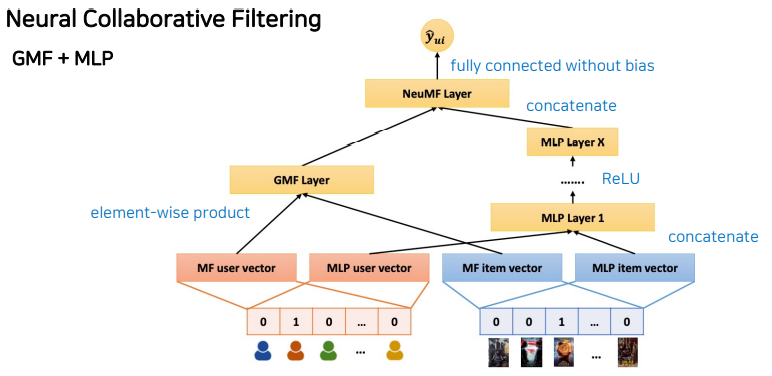

### 파이프라인 구축

#### Dataset Loader

In [160]:
def read_data(data_path):
  df = data_path
  train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
  return train_df, val_df

In [161]:
class DatasetLoader:

    def __init__(self, data_path):
        self.train_df, val_temp_df = read_data(data_path)

        # 최소, 최대 점수 -> 점수 예측 시 표준화를 위해 필요
        # 점수 그대로 활용 (논문에서는 1, 0 으로 변환)
        self.min_rating = min(self.train_df.rate)
        self.max_rating = self.train_df.rate.max()

        # 유저 인덱스화 (onehot vector 에 필요)
        self.unique_users = self.train_df.user.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}

        # 아이템 인덱스화 (onehot vector 에 필요)
        self.unique_items = self.train_df.item.unique()
        self.num_items = len(self.unique_items)
        self.item_to_index = {original: idx for idx, original in enumerate(self.unique_items)}

        self.val_df = val_temp_df[val_temp_df.user.isin(self.unique_users) & val_temp_df.item.isin(self.unique_items)]

    def generate_trainset(self):
        X_train = pd.DataFrame({'user': self.train_df.user.map(self.user_to_index),
                                'item': self.train_df.item.map(self.item_to_index)})
        """ (인덱스화된) user 와 (인덱스화된) item
        user | item
          0  |  0
          0  |  2
          1  |  1
        """
        y_train = self.train_df['rate'].astype(np.float32) # ex. user 0번이 item 0번을 평가한 점수(+감성 점수)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'user': self.val_df.user.map(self.user_to_index),
                              'item': self.val_df.item.map(self.item_to_index)})
        y_val = self.val_df['rate'].astype(np.float32)
        return X_val, y_val

#### Model Structure

In [182]:
class FeedForwardEmbedNN(nn.Module):

    def __init__(self, n_users, n_items, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()

        # 유저, 아이템 Latent Vector
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

        self.drop = nn.Dropout(embedding_dropout)
        # Latent Vector 가 통과할 히든 레이어
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        # 마지막 fully connected layer
        self.fc = nn.Linear(hidden[-1], 1)

    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)

        idx = 0
        # hidden 개수 만큼 layer 생성
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])

            idx += 1

    def forward(self, users, items, min_rating=0.5, max_rating=5):
        # 유저, 아이템 Latent Vector 붙이기
        concat_features = torch.cat([self.user_emb(users), self.item_emb(items)], dim=1)

        # Latent Vector 히든 레이어 통과 -> relu -> fc -> sigmoid -> 최종 예측값
        x = torch.relu(self.hidden_layers(concat_features))
        out = torch.sigmoid(self.fc(x)) # 0, 1
        out = (out * (max_rating - min_rating)) + min_rating # 점수에 맞춰 변환

        return out

    def predict(self, users, items):
        # 점수 예측
        output_scores = self.forward(users, items)
        return output_scores

In [163]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]

In [164]:
def batches(X, y, bs=32, shuffle=True): # batch size : 32
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

#### Train model

In [165]:
def model_train(ds, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 데이터셋 불러오기
    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_items} items')

    # 모델 정의
    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_items=ds.num_items,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )
    model.to(device)

    # 하이퍼파라미터
    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction='sum') # MSE 값으로 평가
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch) # Loss
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train) # 해당 epoch 에서 훈련셋 Loss

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.user.values).to(device),
                            torch.LongTensor(X_valid.item.values).to(device), ds.min_rating, ds.max_rating)
        val_loss = criterion(val_outputs.to(device), torch.FloatTensor(y_valid.values).view(-1, 1).to(device))
        result['val'] = float((val_loss / len(X_valid)).data)
        
        if val_loss < best_loss: # Loss 가 더 떨어질 경우
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            torch.save(model.state_dict(), config['save_path']) # 모델 저장
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [166]:
def model_valid(user_id_list, item_id_list, data_path):
    dataset = DatasetLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'item_id': [dataset.item_to_index[x] for x in item_id_list]
    })

    # 학습한 모델 load
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_items,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     items=torch.LongTensor(processed_test_input_df.item_id.values))

    return prediction_outputs

In [ ]:
# df_fashion_review = pd.read_csv('./fashion_user_item_review.csv') 
df_fashion_review = df_fashion_review[['rate', 'user_id', 'item_id', 'review', 'timestamp']]
df_fashion_review.head()

In [ ]:
df_fashion_review.columns = ['rate', 'user', 'item', 'review', 'timestamp']

In [168]:
# trainset, valset 생성
dataset = DatasetLoader(df_fashion_review)

In [169]:
# 하이퍼파라미터
config = {
  "num_factors": 16,
  "hidden_layers": [64, 32, 16],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 8,
  "num_epochs": 5,
  "total_patience": 30,
  "save_path": "params.data"
}

In [183]:
# 모델 훈련
model_train(dataset, config)

TrainSet Info: 84825 users, 8829 items


Save new model on epoch: 1
[epoch: 1] train: 1.804411324118338 - val: 1.3113079071044922
Save new model on epoch: 2
[epoch: 2] train: 1.1198598064375633 - val: 1.1192176342010498
Save new model on epoch: 3
[epoch: 3] train: 0.7045979800448754 - val: 1.000170111656189
[epoch: 4] train: 0.5443380435483796 - val: 1.0475491285324097
Save new model on epoch: 5
[epoch: 5] train: 0.6889971105460124 - val: 0.9685044884681702



{'best_loss': tensor(2246.9304, device='cuda:0', grad_fn=<MseLossBackward>),
 'train': 0.6889971105460124,
 'val': 0.9685044884681702}

In [184]:
train, val = read_data(df_fashion_review)

In [185]:
# 상품을 추천받을 user id
user_id = 'A32M1OZKT7IC43'

condition = df_fashion_review.user != user_id
item_id_list = train[condition]['item'].values

In [186]:

# 추천
user_id_list = [user_id] * len(item_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, item_id_list, df_fashion_review)]

result_df = pd.DataFrame({
    'userId': user_id_list,
    'itemId': item_id_list,
    # 상품 메타 데이터
    # 'itemName': [itemName_dict[x] for x in item_id_list],
    'pred_ratings': pred_results
})

recommend = result_df.sort_values(by='pred_ratings', ascending=False)
recommend.drop_duplicates(subset=['itemId'], inplace=True)
print(recommend[:10]['itemId'].values) # 상위 10개 상품
recommend[:10]

['B000PHANNM' 'B002Z3N1HE' 'B005AGO4LU' 'B00RLSCLJM' 'B0092UF54A'
 'B018TNFNGA' 'B0058YEJ5K' 'B0091M52CE' 'B00I57ZH9Y' 'B01CEZSSXY']


,userId,itemId,pred_ratings
49457,A32M1OZKT7IC43,B000PHANNM,3.047938
37783,A32M1OZKT7IC43,B002Z3N1HE,2.949980
74785,A32M1OZKT7IC43,B005AGO4LU,2.891871
37798,A32M1OZKT7IC43,B00RLSCLJM,2.858982
68355,A32M1OZKT7IC43,B0092UF54A,2.856357
32777,A32M1OZKT7IC43,B018TNFNGA,2.829421
69996,A32M1OZKT7IC43,B0058YEJ5K,2.822588
1079,A32M1OZKT7IC43,B0091M52CE,2.765693
40236,A32M1OZKT7IC43,B00I57ZH9Y,2.758591
86350,A32M1OZKT7IC43,B01CEZSSXY,2.757897


In [189]:

# 상품 이미지 확인 (메타 데이터 활용)
import requests
import io
import PIL

temp = ['B00G8Q7JZ4', 'B01B5BWTNS', 'B00D8FJF6O', 'B00RLSCLJM', 'B00XT15P8E',
        'B000PHANNM', 'B01BKVWKCS', 'B01ETKKP60', 'B01EL76Y8E', 'B003WJXKTO']

for item in temp:
  print(item)
  url = item_info_df[(item_info_df.asin == item)]['image'].values
  if len(url) <= 1:
    continue
  file = url[0][0]
  print(file)

  response = requests.get(file)
  image_bytes = io.BytesIO(response.content)

  img = PIL.Image.open(image_bytes)
  img.show()

B00G8Q7JZ4
B01B5BWTNS
B00D8FJF6O
B00RLSCLJM
B00XT15P8E
B000PHANNM
B01BKVWKCS
B01ETKKP60
B01EL76Y8E
B003WJXKTO


In [190]:
!pip3 freeze > requirements.txt

In [191]:
!pip install pyyaml h5py  # HDF5 포맷으로 모델을 저장하기 위해서 필요합니다